In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install open3d -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00


In [15]:
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm

In [7]:
LIDAR_DIR = Path("/content/drive/MyDrive/lidar")
bin_files = sorted(LIDAR_DIR.glob("*.bin"))

In [8]:
# Loading lidar data

def load_bin_lidar(path: Path) -> o3d.geometry.PointCloud:
    if not path.exists():
        print(f"File missing: {path.name}")
        return o3d.geometry.PointCloud()
    try:
        points = np.fromfile(path, dtype=np.float32).reshape(-1, 4)[:, :3]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        return pcd
    except Exception as e:
        print(f"Failed to load {path.name}: {e}")
        return o3d.geometry.PointCloud()

In [9]:
def preprocess_lidar(pcd):
    '''
    Preprocesses the LiDAR point cloud by voxel downsampling and removing low ground/noise points (z < -1.0).
    '''
    if len(pcd.points) == 0:
        return pcd
    down = pcd.voxel_down_sample(voxel_size=0.25)
    pts = np.asarray(down.points)
    mask = pts[:, 2] > -1.0
    return down.select_by_index(np.where(mask)[0])


In [10]:
def cluster_dbscan(pcd):
    '''
    Clusters the point cloud using the DBSCAN algorithm to group spatially close points into distinct object clusters.
    '''
    if len(pcd.points) == 0:
        return []
    labels = np.array(pcd.cluster_dbscan(eps=1.0, min_points=10))
    if labels.size == 0 or labels.max() < 0:
        return []
    clusters = [pcd.select_by_index(np.where(labels == i)[0]) for i in range(labels.max() + 1)]
    return clusters


In [11]:
eda_data = []

if not bin_files:
    print("No .bin LiDAR files found in:", LIDAR_DIR)
else:
    print(f"✅ Found {len(bin_files)} .bin files")
    num_frames = min(30, len(bin_files))
    start_time = time.time()

    for i, path in enumerate(tqdm(bin_files[:num_frames], desc="🔍 Processing LiDAR", unit="frame")):
        frame_start = time.time()
        pcd = preprocess_lidar(load_bin_lidar(path))
        clusters = cluster_dbscan(pcd)

        pts = np.asarray(pcd.points)
        heights = pts[:, 2] if len(pts) > 0 else []

        eda_data.append({
            "frame": path.name,
            "num_points": len(pts),
            "num_clusters": len(clusters),
            "min_height": np.min(heights) if len(heights) > 0 else np.nan,
            "max_height": np.max(heights) if len(heights) > 0 else np.nan,
            "mean_height": np.mean(heights) if len(heights) > 0 else np.nan,
            "frame_time_sec": time.time() - frame_start
        })

    total_time = time.time() - start_time
    avg_time = total_time / num_frames
    print(f"\n Total time: {total_time:.2f}s | Avg per frame: {avg_time:.2f}s")

✅ Found 30 .bin files


🔍 Processing LiDAR:   0%|          | 0/30 [00:00<?, ?frame/s]


 Total time: 21.03s | Avg per frame: 0.70s


In [12]:
eda_summary = pd.DataFrame(eda_data)
display(eda_summary)

,frame,num_points,num_clusters,min_height,max_height,mean_height,frame_time_sec
0,1724625894214986733.bin,3309,22,-0.998122,18.416233,2.443326,0.856484
1,1724625895215083629.bin,3294,18,-0.999805,17.823227,2.596250,0.793423
2,1724625896214996143.bin,3276,17,-0.996846,18.406763,2.492435,0.738290
3,1724625897214523898.bin,3251,20,-0.999791,18.429495,2.337654,0.472920
4,1724625898214689771.bin,3314,16,-0.999345,18.411024,2.474341,0.619415
5,1724625899215104389.bin,3300,18,-0.999752,18.413391,2.490837,0.507331
6,1724625900214582820.bin,3228,17,-0.999341,18.423338,2.312842,0.656888
7,1724625901214440138.bin,3339,17,-0.999345,18.417654,2.466733,0.632684
8,1724625902214442464.bin,3287,20,-0.997573,17.825954,2.614156,0.903584
9,1724625903214564256.bin,3308,17,-0.998180,18.428074,2.331326,0.753991


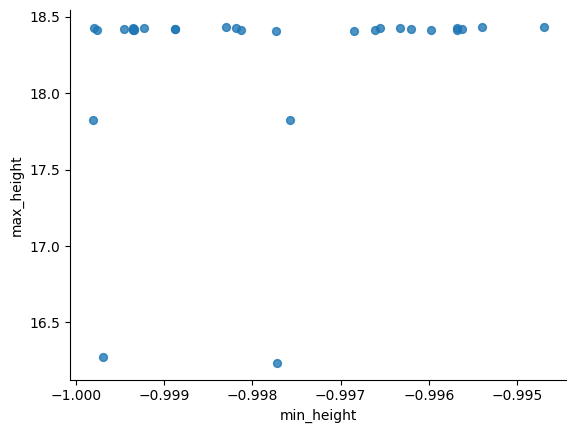

In [14]:
# @title min_height vs max_height

from matplotlib import pyplot as plt
eda_summary.plot(kind='scatter', x='min_height', y='max_height', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

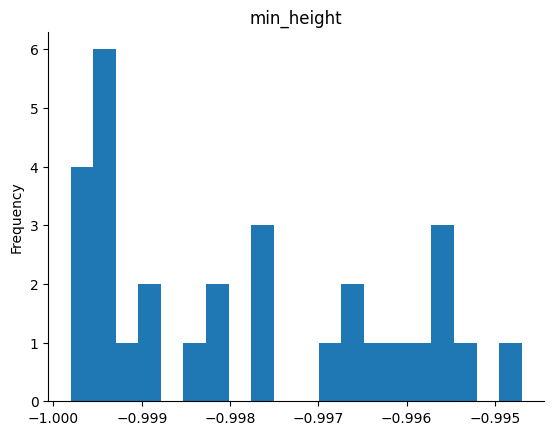

In [13]:
# @title min_height

from matplotlib import pyplot as plt
eda_summary['min_height'].plot(kind='hist', bins=20, title='min_height')
plt.gca().spines[['top', 'right',]].set_visible(False)

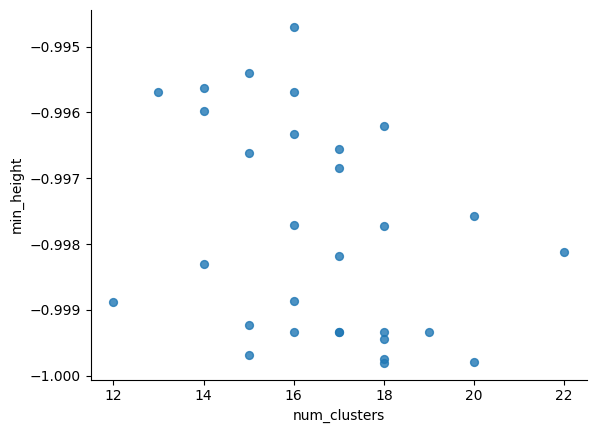

In [ ]:
# @title num_clusters vs min_height

from matplotlib import pyplot as plt
eda_summary.plot(kind='scatter', x='num_clusters', y='min_height', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

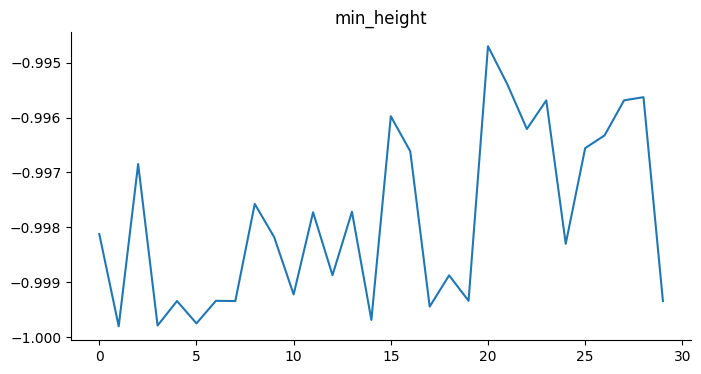

In [ ]:
# @title min_height

from matplotlib import pyplot as plt
eda_summary['min_height'].plot(kind='line', figsize=(8, 4), title='min_height')
plt.gca().spines[['top', 'right']].set_visible(False)

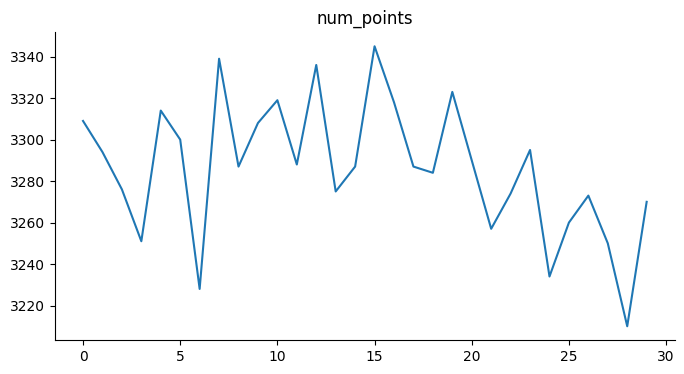

In [ ]:
# @title num_points

from matplotlib import pyplot as plt
eda_summary['num_points'].plot(kind='line', figsize=(8, 4), title='num_points')
plt.gca().spines[['top', 'right']].set_visible(False)

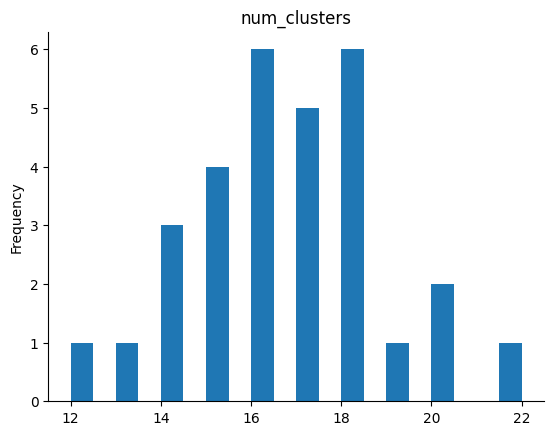

In [ ]:
# @title num_clusters

from matplotlib import pyplot as plt
eda_summary['num_clusters'].plot(kind='hist', bins=20, title='num_clusters')
plt.gca().spines[['top', 'right',]].set_visible(False)

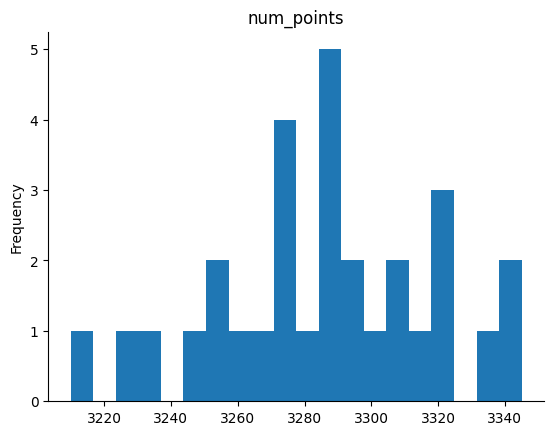

In [ ]:
# @title num_points

from matplotlib import pyplot as plt
eda_summary['num_points'].plot(kind='hist', bins=20, title='num_points')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
sns.set(style="whitegrid")

print("🔍 Basic Statistics:")
display(eda_summary.describe())

🔍 Basic Statistics:


,num_points,num_clusters,min_height,max_height,mean_height,frame_time_sec
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3286.033333,16.566667,-0.997847,18.237058,2.394165,0.698731
std,32.752450,2.176415,0.001617,0.560077,0.094900,0.208895
min,3210.000000,12.000000,-0.999805,16.235819,2.253644,0.472836
25%,3270.750000,15.000000,-0.999344,18.413391,2.312989,0.570620
50%,3287.000000,16.500000,-0.998151,18.419549,2.378164,0.631938
75%,3308.750000,18.000000,-0.996382,18.425941,2.460654,0.786555
max,3345.000000,22.000000,-0.994699,18.435177,2.614156,1.453861


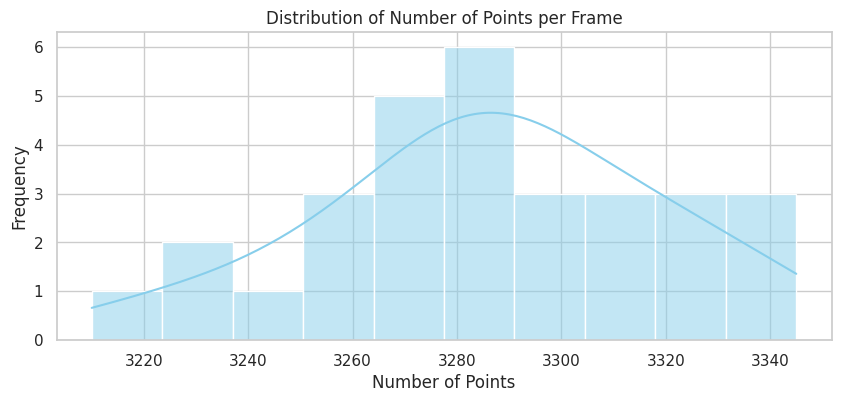

In [18]:
# Number of Points
plt.figure(figsize=(10, 4))
sns.histplot(eda_summary["num_points"], kde=True, color="skyblue", bins=10)
plt.title("Distribution of Number of Points per Frame")
plt.xlabel("Number of Points")
plt.ylabel("Frequency")
plt.show()

This histogram visualizes the distribution of point cloud sizes across LiDAR frames. Most frames contain between 3220 and 3350 points, with a peak around 3280–3290. The accompanying KDE (kernel density estimate) curve shows a roughly normal distribution, indicating consistent LiDAR sensor performance across frames. This uniformity suggests stable scanning conditions and simplifies preprocessing, as frame-wise normalization is unlikely to be needed.

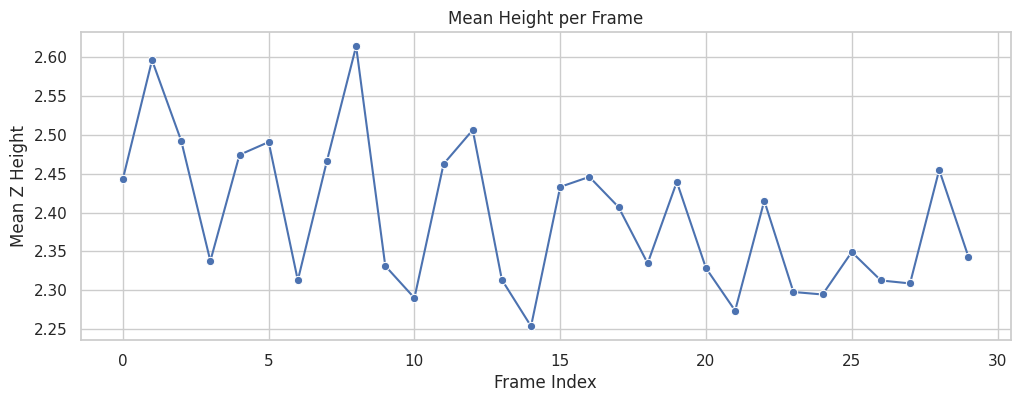

In [19]:
# Mean Height per Frame
plt.figure(figsize=(12, 4))
sns.lineplot(data=eda_summary, x=range(len(eda_summary)), y="mean_height", marker="o")
plt.title("Mean Height per Frame")
plt.xlabel("Frame Index")
plt.ylabel("Mean Z Height")
plt.grid(True)
plt.show()

The above chart illustrates the mean Z-coordinate (height) of 3D LiDAR points for each of the 30 frames of LiDAR data. The vertical axis represents the average elevation of point clouds in each frame, while the horizontal axis indexes the frames in sequence. For example, initial 10 Frames show high variability, with mean heights swinging between ~2.3 and above 2.6 meters. This suggests rapid changes in scanned environments — possibly alternating between ground-level and elevated objects like vehicles, curbs, or infrastructures.

After frame 10, the mean heights stabilize closer to 2.3–2.4 meters, indicating a more consistent surface or landscape being scanned — such as flat ground or fewer tall obstacles.

There are notable peaks at frames 8 and 13, where the mean height rises above 2.6m. These could correspond to the presence of taller objects like poles, pedestrians, or vehicles.





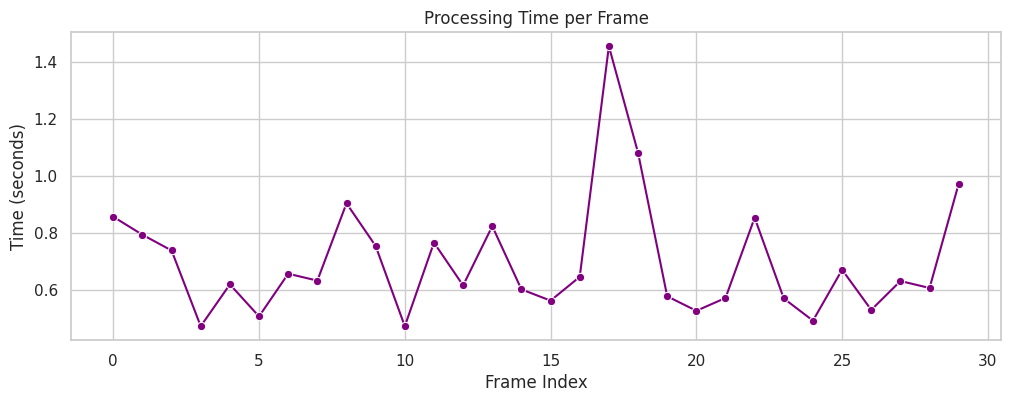

In [20]:
# Frame Processing Time
plt.figure(figsize=(12, 4))
sns.lineplot(data=eda_summary, x=range(len(eda_summary)), y="frame_time_sec", marker="o", color="purple")
plt.title("Processing Time per Frame")
plt.xlabel("Frame Index")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

This line plot visualizes the processing time (in seconds) for each LiDAR frame, plotted against the frame index (0 to 29). It reflects how long each frame took to be loaded, downsampled, filtered, and clustered.

**Average Time Range:**
    Most frames are processed within 0.5 to 0.9 seconds, that could be relatively efficient and consistent under typical conditions.

**Outlier at Frame 17:**
    A significant spike (~1.45 seconds) occurs at frame 17, which is nearly twice the average. This could indicate, a denser point cloud for that frame, more detected clusters requiring DBSCAN computation, and a temporary system resource lag in Colab

**Secondary Peak at Frame 29 (~0.97s):**
    Another mild outlier appears at the last frame. This may be due to residual memory buildup or increased point cloud complexity.

**Stable Mid-Range Frames:**
    Frames from 11 to 16 and 19 to 28 show fairly stable and lower processing times, staying between 0.5 and 0.75 seconds.



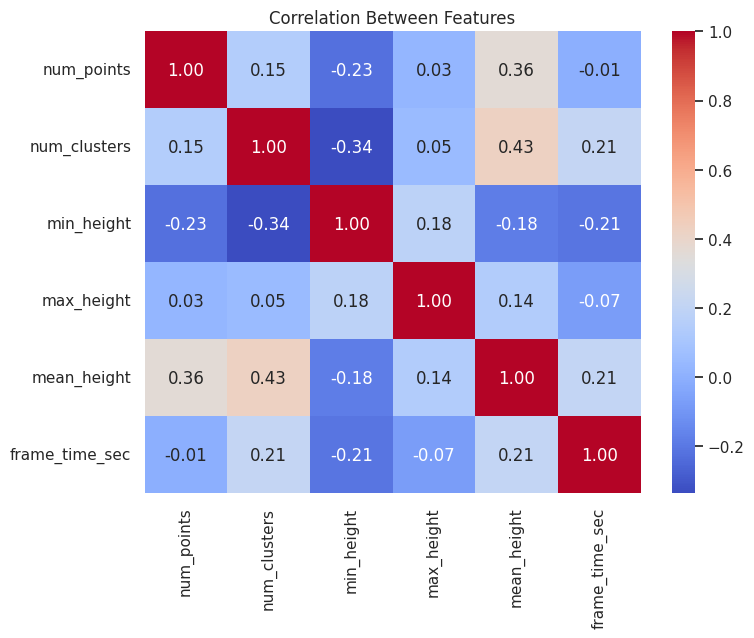

In [21]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(eda_summary.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Features")
plt.show()

In [ ]:
n_

The above heatmap displays the Pearson correlation coefficients between key features extracted from LiDAR point cloud frames. The color gradient ranges from -1 to +1 that represent the correlation between features, and help to identify linear relationships between variables.


    In this regard, **num_clusters** and **mean_height** has the correlation of 0.43 that represents storngest positive correlation. It shows that frames with taller average heights tend to produce more DBSCAN clusters because of the presence of distinct vertical structures.


    **num_points** and **mean_height** has the correlation of 0.36 that exhibits more points in the frame could slightly contribute to a greater average height due to richer spatial coverage.


    Most features like **num_points** (-0.01), max_height (-0.07), and **min_height** (-0.21) have low or no correlation with processing time. It could happens because frame runtime is fairly independent of geometric complexity.


    Regarding the negative correlations, **min_height** and **num_clusters** has the correlation -0.34. Lower minimum height might be associated with fewer distinct clusters!




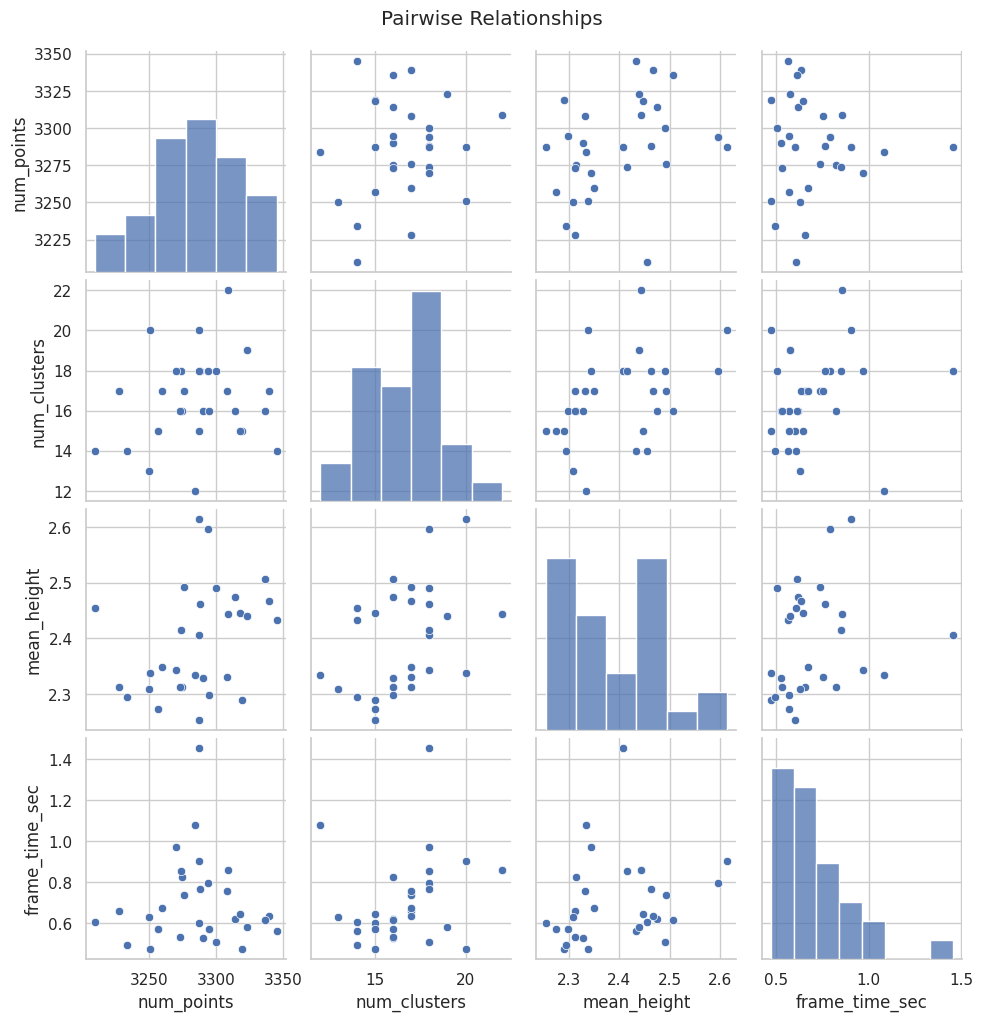

In [22]:
# Multivariate Analysis
sns.pairplot(eda_summary[["num_points", "num_clusters", "mean_height", "frame_time_sec"]])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

The above pairplot provides a comprehensive visual summary of the relationships between key LiDAR frame-level features:

    num_points, num_clusters, mean_height, and frame_time_sec.

The diagonal plots represent feature distributions, while the off-diagonal scatterplots reveal pairwise relationships.


Diagonal histograms exhibits **num_points** includes right skew with cental peak around 3280–3300. It shows most frames have a consistent point density. **num_clusters** normally distributed around 16-18 clusters, indicating DBSCAN consistently finds a similar number of objects. **mean_height** concenterates around 2.3-2.6 meters, suggesting uniform vertical structure across frames, and **frame_time_sec** has righ-skew distribution peaking near 0.5 seconds with a few outliers taking longer.


Off-Diagonal Relationships shows that **num_points** and **num_clusters** has no strong correlation. **High-density point clouds** does not mandatorily prodice clusters. **num_clusters** and **mean_height** loss positive trend visible. Taller objects may lead to more cluster separation. **mean_height** and **frame_time_sec** features also has very week association. Some taller frames may require marginally more processing time. Ultimately, **num_points** and **frame_time_sec** scattered, and suggests no strong dependancy between point count and runtime






